In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# import arya
import seaborn as sns

In [9]:
from glob import glob as glob

In [19]:
filename = "orbits/out/snapshot_000.hdf5"
f0 = h5py.File(filename, "r")

In [23]:
def get_xy(f):
    pos = f[('PartType1/Coordinates')][()]
    x = pos[:, 0]
    y = pos[:, 1]
    z = pos[:, 2]
    return x, y, z

In [37]:
np.array([x, y]).transpose

<function ndarray.transpose>

MovieWriter ffmpeg unavailable; using Pillow instead.


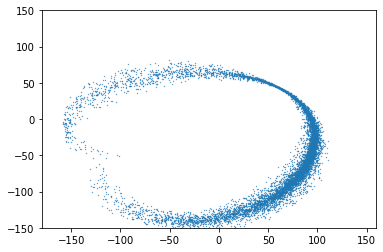

In [39]:
x, y, z = get_xy(f0)
fig = plt.figure()
scat = plt.scatter(x, z, s=0.1)

fnames = glob("orbits/out/snapshot*.hdf5")
plt.xlim(-180, 160)
plt.ylim(-150, 150)
    
def update_fig(i, scat):
    f = h5py.File(fnames[i], "r")
    x, y, z = get_xy(f)
    scat.set_offsets(np.array([x, z]).transpose())
    f.close()
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(len(fnames)),
                                  fargs=(scat,))

ani.save("orbit.gif")
plt.show()

In [3]:
pos = f[('PartType1/Coordinates')][()]
x = pos[:, 0]
y = pos[:, 1]
z = pos[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)

vel = f[('PartType1/Velocities')][()]
vx = vel[:, 0]
vy = vel[:, 1]
vz = vel[:, 2]
v = np.sqrt(vx**2 + vy**2 + vz**2)

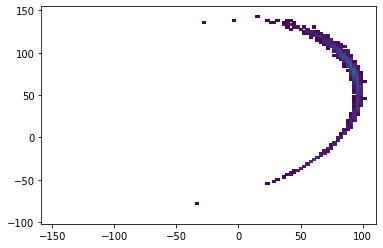

In [8]:
plt.hist2d(x, y, norm=mpl.colors.LogNorm(10, 1e5), cmin=10, bins=100);

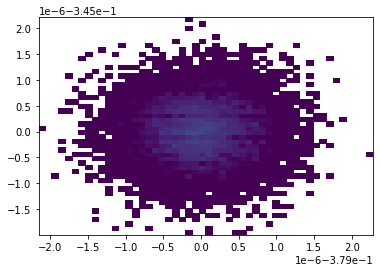

In [94]:
plt.hist2d(vx, vz, norm=mpl.colors.LogNorm(10, 1e5), cmin=1, bins=50);

In [40]:
import astropy

In [41]:
from astropy.coordinates import Galactocentric

In [42]:
Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

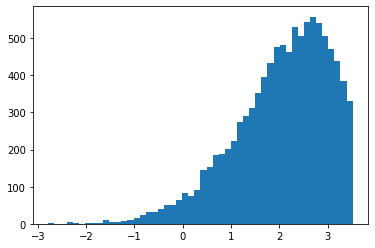

In [17]:
plt.hist(np.log(r), 50);Galactocentric

Text(0, 0.5, 'v')

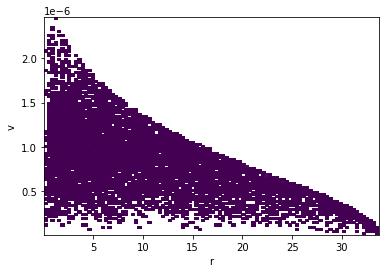

In [18]:
plt.hist2d(r, v, norm=mpl.colors.LogNorm(10, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")

Text(0.5, 0, 'R')

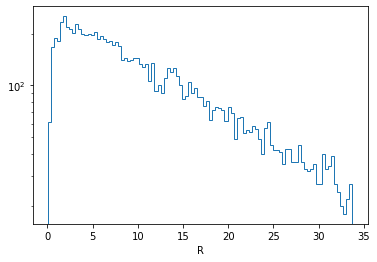

In [32]:
plt.hist(r, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

In [27]:
f1 = h5py.File("isolation/out/snapshot_001.hdf5", "r")

In [28]:
pos1 = f1["PartType1/Coordinates"][()]
x1 = pos1[:, 0]
y1 = pos1[:, 1]
z1 = pos1[:, 2]
r1 = np.sqrt(x1**2 + y1**2 + z1**2)
vel1 = f1["PartType1/Velocities"][()]
vx1 = vel1[:, 0]
xy1 = vel1[:, 1]
vz1 = vel1[:, 2]
v1 = np.sum(vel1**2, axis=1)
r1 = np.sum(pos1**2, axis=1)

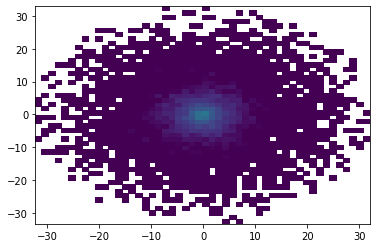

In [29]:
dx = 100
n_bin = 50
plt.hist2d(x1, y1, norm=mpl.colors.LogNorm(10, 1e5), cmin=1, bins=50);

Text(0.5, 0, 'R')

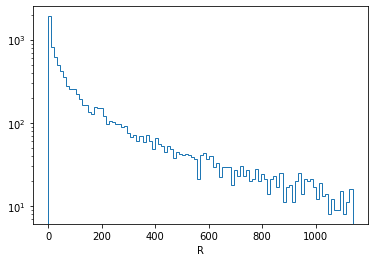

In [31]:
plt.hist(r1, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

Text(0, 0.5, 'v')

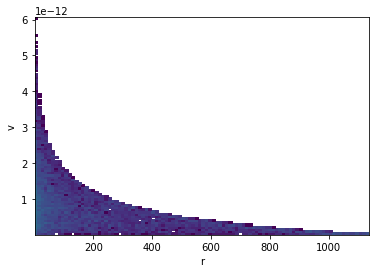

In [39]:
dx = 30
dy = 1e-10
n_bin = 50
plt.hist2d(r1, v1, norm=mpl.colors.LogNorm(1, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")